In [1]:
! pip install --quiet transformers 
! pip install --quiet datasets 
! pip install --quiet lime
! pip install --quiet emoji
 
import re
import emoji
import pandas as pd
import tensorflow as tf
import statsmodels

from datasets import load_dataset

from lime.lime_text import LimeTextExplainer
from lime import submodular_pick

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.special import expit, softmax


from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

import statsmodels.formula.api as smf



     |████████████████████████████████| 2.6 MB 12.2 MB/s 
     |████████████████████████████████| 895 kB 62.6 MB/s 
     |████████████████████████████████| 3.3 MB 56.1 MB/s 
     |████████████████████████████████| 636 kB 62.9 MB/s 
     |████████████████████████████████| 264 kB 14.9 MB/s 
     |████████████████████████████████| 118 kB 29.5 MB/s 
     |████████████████████████████████| 76 kB 4.6 MB/s 
     |████████████████████████████████| 243 kB 25.1 MB/s 
     |████████████████████████████████| 275 kB 14.5 MB/s 
     |████████████████████████████████| 184 kB 14.9 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# de-emojify helper function - subbing all emojis (which the tokenizer
# defaults to [UNK]) into the word "emoji" (which the tokenizer recognizes).

import emoji

def de_emoji(string):
  return emoji.get_emoji_regexp().sub(" emoji ", string)

# de-link helper function - subbing all links (which the tokenizer
# either chops meaninglessly or defaults to [UNK]) into the word "link"
# (which the tokenizer recognizes).
def de_link(string):
  return re.sub(r'.http.*', ' link ', string)



In [3]:

#df = pd.read_csv('7_12_data_subset.csv')

#TO DO: preprocess data a bit and see what happpens!

df = pd.read_csv('7_12_19_data_subset.csv', encoding = 'latin-1')
df.loc[df.self_prom.isnull(), 'self_prom'] = 0
df['self_prom'] = df['self_prom'].astype(int)

#Applying preprocessing helper functions
df['tweet_text'] = df['tweet_text'].apply(de_link) 
df['tweet_text'] = df['tweet_text'].apply(de_emoji) 

df = df.sample(frac = 1, random_state = 42)

df = df[['tweet_text', 'self_prom']]
df.rename(columns={'self_prom':'label'} , inplace = True)

train = df[ :int(0.8 * df.shape[0])]
test = df[int(0.8 * df.shape[0]):]

train.to_csv('train.csv', index = False)
test.to_csv('test.csv', index = False)

raw_datasets = load_dataset('csv', data_files = {'train': 'train.csv' ,\
                                            'test':'test.csv'})

#tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-large-portuguese-cased")
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

def tokenize_function(examples):
    return tokenizer(examples["tweet_text"], padding="max_length", max_length = 512, truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

train_df = tokenized_datasets['train']
test_df = tokenized_datasets['test']




Using custom data configuration default-ea02e51644752770


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-ea02e51644752770/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [4]:
# TO DO: GET RECALL,PRECISION BY CLASS

def compute_metrics(pred):
    labels = pred.label_ids
    #print(labels)
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average= None)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [5]:
#model = AutoModelForSequenceClassification.from_pretrained("neuralmind/bert-large-portuguese-cased", num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=2)

# To DO:
# Change toy epoch #
# Play around with weight decay and batch_num parms
#

training_args = TrainingArguments("test_trainer")
training_args.num_train_epochs = 5.0
training_args.learning_rate = 1e-05


trainer = Trainer(
    model=model, args=training_args, compute_metrics=compute_metrics, train_dataset=train_df, eval_dataset=test_df
)

trainer.train()

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Step,Training Loss
500,0.341500
1000,0.219000
1500,0.147600
2000,0.086700


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2000
Configuration saved in test_trainer/checkpoint-2000/config.json
Model weights saved in test_trainer/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2485, training_loss=0.17075455817178462, metrics={'train_runtime': 679.8485, 'train_samples_per_second': 29.227, 'train_steps_per_second': 3.655, 'total_flos': 5228016670003200.0, 'train_loss': 0.17075455817178462, 'epoch': 5.0})

In [6]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet_text.
***** Running Evaluation *****
  Num examples = 994
  Batch size = 8


Trainer is attempting to log a value of "[0.93832021 0.79741379]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9457672  0.77731092]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.93098958 0.81858407]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 5.0,
 'eval_accuracy': 0.9054325955734407,
 'eval_f1': array([0.93832021, 0.79741379]),
 'eval_loss': 0.4695739448070526,
 'eval_precision': array([0.9457672 , 0.77731092]),
 'eval_recall': array([0.93098958, 0.81858407]),
 'eval_runtime': 10.7861,
 'eval_samples_per_second': 92.155,
 'eval_steps_per_second': 11.589}

In [7]:
#Predict on archival unit test here. Make it so that you can choose the confidence threshold at which to classify a tweet as self-prom.

#Staging.

arch = pd.read_csv('archive_tweets_final.csv', encoding = 'latin-1')

# We'll have to use a subset - takes too long and times out otherwise. 
# Started with 434K, going down to 87K.

arch = arch.sample(frac = .2, random_state = 42)

arch.to_csv('archive_tweets_subset_final.csv', encoding = 'latin-1')

#As with the corpus data, preprocessing.
arch['tweet_text'] = arch['tweet_text'].apply(de_link) 
arch['tweet_text'] = arch['tweet_text'].apply(de_emoji) 

arch = arch[['tweet_text']]
arch.to_csv('archive_tweets_staged.csv', index = False)

arch_dataset = load_dataset('csv', data_files = {'archive':'archive_tweets_staged.csv'})

#tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-large-portuguese-cased")
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")


#TO DO: Examine "default to no padding" / "default to no truncation" warnings
tokenized_datasets = arch_dataset.map(tokenize_function, batched=True)

archive_df = tokenized_datasets['archive']

final_preds = trainer.predict(archive_df)


Using custom data configuration default-71ace187ebf823dd


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-71ace187ebf823dd/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


loading configuration file https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e716e2151985ba669e7197b64cdde2552acee146494d40ffaf0688a3f152e6ed.18a0b8b86f3ebd4c8a1d8d6199178feae9971ff5420f1d12f0ed8326ffdff716
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "tra

  0%|          | 0/87 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet_text.
***** Running Prediction *****
  Num examples = 86811
  Batch size = 8


In [28]:
#quick helper function to softmax predictions, classify class 1 (i.e. self-promotion) 
#according to a user-specced level, append the vector to the archives file
#and save it.  

def check_probs(x, confidence_level = .6):
  preds_array = []
  for row in expit(x[0]):
    if row[1] >= confidence_level:
      preds_array.append(1)
    else:
      preds_array.append(0)
  
  return pd.Series(preds_array)

self_prom_preds = check_probs(final_preds)

arch_predicted = pd.read_csv('archive_tweets_subset_final.csv', encoding= 'latin-1')

arch_predicted = arch_predicted.assign(self_prom = self_prom_preds.values)

arch_predicted.to_csv('archived_tweets_w_preds.csv', index = False)

In [9]:
# Put LIME code here

#LIME-friendly predict function
def lime_pred(df):
  df = pd.DataFrame(df, columns = ['tweet_text'])

  #This is a super wasteful step, but haven't been able to run code 
  #without it. To clean up if this project ever goes forward.
  
  df.to_csv('lime_explainer.csv', index = False)

  tf_ds = load_dataset('csv', data_files = 'lime_explainer.csv')
  tokenized_ds = tf_ds.map(tokenize_function, batched=True)
  #tokenized_ds= tokenized_datasets['sm_pick']

  return trainer.predict(tokenized_ds['train'])[0]

# RO DO 

#Cutting LIME and ourselves some slack - we're only interested in 
# cases in our predicted archive where self_promotion = 1.


explainer = LimeTextExplainer()

sm_pick = submodular_pick.SubmodularPick(explainer, arch['tweet_text'].to_numpy(), lime_pred, sample_size = 10)


#arch['tweet_text']


#predict_probas = trainer.predict(test_df)
#print(type(predict_probas))



Using custom data configuration default-cb77d44b378fd377


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-cb77d44b378fd377/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet_text.
***** Running Prediction *****
  Num examples = 5000
  Batch size = 8


Using custom data configuration default-f2377f37437edc42


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f2377f37437edc42/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet_text.
***** Running Prediction *****
  Num examples = 5000
  Batch size = 8
Using custom data configuration default-4a3aaf31fd19bdce


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4a3aaf31fd19bdce/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet_text.
***** Running Prediction *****
  Num examples = 5000
  Batch size = 8
Using custom data configuration default-50102abd36348410


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-50102abd36348410/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet_text.
***** Running Prediction *****
  Num examples = 5000
  Batch size = 8
Using custom data configuration default-37be875b3418ec3c


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-37be875b3418ec3c/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet_text.
***** Running Prediction *****
  Num examples = 5000
  Batch size = 8
Using custom data configuration default-d8f5d5c0a51d7a73


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-d8f5d5c0a51d7a73/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet_text.
***** Running Prediction *****
  Num examples = 5000
  Batch size = 8
Using custom data configuration default-cbfbcb3f8c553a7f


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-cbfbcb3f8c553a7f/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet_text.
***** Running Prediction *****
  Num examples = 5000
  Batch size = 8
Using custom data configuration default-e7c1af22f3bc119e


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-e7c1af22f3bc119e/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet_text.
***** Running Prediction *****
  Num examples = 5000
  Batch size = 8
Using custom data configuration default-2c69f78bb55ed52c


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-2c69f78bb55ed52c/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet_text.
***** Running Prediction *****
  Num examples = 5000
  Batch size = 8
Using custom data configuration default-60b9021e20e9d16a


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-60b9021e20e9d16a/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet_text.
***** Running Prediction *****
  Num examples = 5000
  Batch size = 8


5


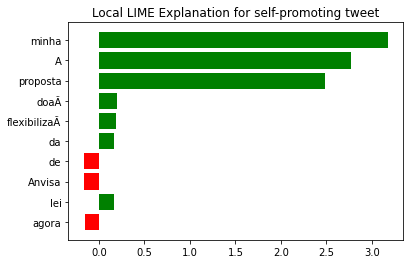

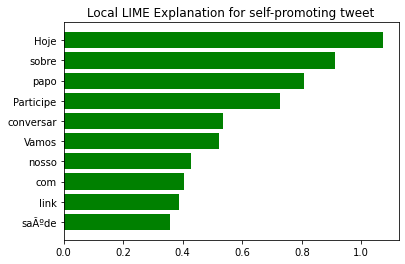

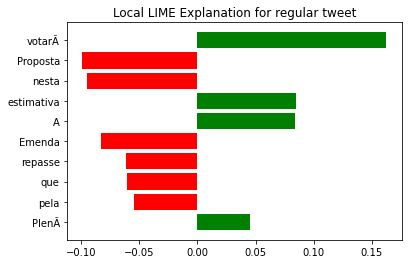

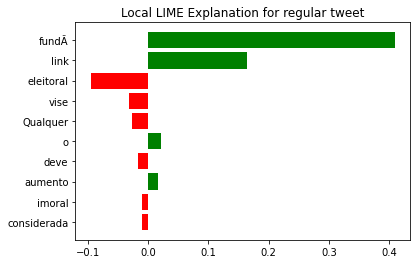

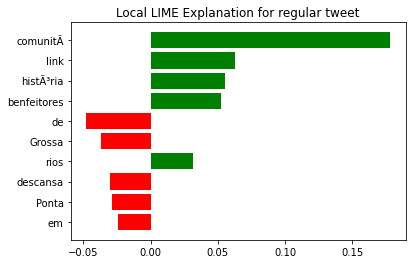

In [12]:

#[exp.as_pyplot_figure() for exp in sm_pick.sp_explanations]

#sm_pick.sp_explanations

#explainer.as_pyplot_figure(sm_pick.sp_explanations[0])

import matplotlib.pyplot as plt
import numpy as np

print( len(sm_pick.sp_explanations))

for i in range( len(sm_pick.sp_explanations)):

  try:
    y = sm_pick.sp_explanations[i].as_list(1)
    title = 'Local LIME Explanation for self-promoting tweet' 

    vals = [ each[1] for each in y]
    labels = [ each[0] for each in y]

    labels.reverse()
    vals.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]

    pos = np.arange(len(vals)) + .5

    plt.barh(pos, vals, align='center', color=colors);
    plt.yticks(pos, labels)

    plt.title(title)
    plt.show()
  
  except:
    y = sm_pick.sp_explanations[i].as_list(0)
    title = 'Local LIME Explanation for regular tweet'


    
    vals = [ each[1] for each in y]
    labels = [ each[0] for each in y]

    labels.reverse()
    vals.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]

    pos = np.arange(len(vals)) + .5

    plt.barh(pos, vals, align='center', color=colors);
    plt.yticks(pos, labels)

    plt.title(title)
    plt.show()
    
  




In [53]:
# Run GLM on predictions here.

import pandas as pd

df = pd.read_csv("archived_tweets_w_preds.csv", encoding = 'latin-1')

#First, make columns regression-friendly:
df['log_followers'] = df['num_followers'].apply(np.log)

df['age_days'] = pd.Timestamp.now().normalize() - pd.to_datetime(df.DOB)
df['age_yrs'] = df.age_days.apply(lambda x: x.days) / 365
df['age_yrs'] = df.age_yrs.apply(round)

#Making dummy variables: Will do one for female and one for senate (i.e.
# baseline is a male rep, which is indeed the most frequent subpop in the
# gender/position cross-section)
df['female'] = df.gender.apply(lambda x: '1' if x == 'F' else 0)
df['senator'] = df.house.apply(lambda x: '1' if x == 'senator' else 0)

dummies = pd.get_dummies(df['pol_party'])
#Need k-1 for k dummies - dropping the variable for REDE, the smallest
#political party in our pop (3 members of congress)

if 'REDE' in dummies.columns:
  dummies.drop('REDE', inplace=True, axis=1)

#Just realized I also need dummies for author...
#No particular ex-ante preference for which author
# to exclude, so letting drop_first = True.

#Have to preprocess columns so statsmodels doesnt throw an error - 
# getting each MoC's last name (which I've checked - they don't conflit)

df['last_name'] = df['name_congressperson'].str.split().apply(lambda x: x[-1])


df['last_name'] = df['last_name'].apply(lambda x: re.sub("[^0-9a-zA-Z]+", "AA", x))
dummies_auth = pd.get_dummies(df['last_name'], drop_first = True)


#Normalizing tweet dates to 'yyyy-mm'
#df['date'] = df['created_at'].str.slice(0, 10)
df['date'] = df['created_at'].str.slice(0, 7)


#Finally, keeping only the relevant columns and adding in the dummies.

#df = df[['author_id', 'date' , 'senator', 'num_terms' ,'age_yrs', 'log_followers' , 'female' , 'self_prom' ]]

df = df[['author_id', 'date' , 'senator', 'num_terms' ,'age_yrs', 'log_followers' , 'female' , 'self_prom', 'last_name' ]]


#df = pd.concat([df, dummies, dummies_auth], axis=1)
df = pd.concat([df, dummies], axis=1)



In [54]:
df['last_name']

0           Macris
1             MOTA
2         VALENTIM
3           Mattos
4            Tatto
           ...    
86806        Diniz
86807        Braga
86808    Rodrigues
86809    Sanderson
86810      Pereira
Name: last_name, Length: 86811, dtype: object

In [57]:
#Running the mixed-effects regression. Moment of truth!

# Setting up strings for regression


# Getting in all the dummy names for political party 
pp_dmat = ''
for prt in dummies.columns[:-1]:
  pp_dmat += (prt + ' + ')

auth_dmat = ''
for auth in dummies_auth.columns[:-1]:
  auth_dmat += (auth + ' + ')

# Other fixed effects  - as per Jun et al. - have all but daily num of
# tweets, which I wasn't able to capture.
#fix_fx = 'female + senator + num_terms + age_yrs + log_followers +' + pp_dmat[:-2] + '+' + auth_dmat[:-2]
print(fix_fx)


fix_fx = 'female + senator + num_terms + age_yrs + log_followers +' + pp_dmat[:-2] + '+ date'

reg = smf.mixedlm( ('self_prom ~ ' + fix_fx), df, groups = df['last_name'])


reg_run = reg.fit()

print(reg_run.summary())

female + senator + num_terms + age_yrs + log_followers +AVANTE + CIDADANIA + DEM + MDB + NOVO + PATRIOTA + PCdoB + PDT + PL + PODE + PODEMOS + PP + PROS + PSB + PSC + PSD + PSDB + PSL + PSOL + PT + PTB + PV + REPUBLICANOS + date -1
           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: self_prom  
No. Observations:   86811   Method:             REML       
No. Groups:         407     Scale:              0.1618     
Min. group size:    1       Likelihood:         -44857.9180
Max. group size:    1582    Converged:          Yes        
Mean group size:    213.3                                  
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        0.753    0.042  17.990 0.000  0.671  0.835
female[T.1]      0.023    0.011   2.005 0.045  0.001  0.045
senator[T.1]     0.037    0.022   1.671 0.095 -0.006  0.080

In [61]:
reg_run.aic

nan